In [625]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial
import pandas as pd

In [626]:
array_data = "C:/Users/peyto/Documents/schol/code//SCQED-PCQED/array_data"
cavity_E_array_0_00_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0.npy").T
cavity_E_array_0_001_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_001.npy").T
cavity_E_array_0_005_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_005.npy").T
cavity_E_array_0_01_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_01.npy").T
cavity_E_array_0_02_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_02.npy").T
cavity_E_array_0_03_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_03.npy").T
cavity_E_array_0_04_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_04.npy").T
cavity_E_array_0_05_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_05.npy").T
dipoles_0 = np.load(array_data + "/HF/dipoles_HF0.npy")
dipoles_001 = np.load(array_data + "/HF/dipoles_HF0_001.npy")
dipoles_005 = np.load(array_data + "/HF/dipoles_HF0_005.npy")
dipoles_01 = np.load(array_data + "/HF/dipoles_HF0_01.npy")
dipoles_02 = np.load(array_data + "/HF/dipoles_HF0_02.npy")
dipoles_03 = np.load(array_data + "/HF/dipoles_HF0_03.npy")
dipoles_04 = np.load(array_data + "/HF/dipoles_HF0_04.npy")
dipoles_05 = np.load(array_data + "/HF/dipoles_HF0_05.npy")
r_data = np.load(array_data + "/HF/fci_r_array_HF.npy")
N_R = r_data.shape[0]
r_data = np.linspace(0.5,2.5,N_R)

In [627]:
print(dipoles_0[:,:,:,80])

[[[ 3.31443953e-15  5.06703950e-15  4.25652671e-01]
  [-1.61574155e-13  6.95464507e-14 -9.32096189e-14]
  [-2.05342361e-13 -5.16277797e-16  2.76241441e-15]
  [ 5.45047136e-02 -2.56143350e-02  3.36852316e-14]
  [-2.56143350e-02 -5.45047136e-02  1.36092312e-15]
  [ 1.45048998e-15 -4.78272776e-14  7.48806503e-14]
  [-1.22070585e-15  1.33789222e-15  1.42937142e+00]
  [-2.02487537e-15 -1.01765261e-15  1.05316337e-12]
  [ 9.11924747e-15  4.63553431e-15  1.96250648e-14]
  [-5.47901396e-15  3.11385717e-15 -1.92023292e-14]
  [ 3.09359102e-15 -1.73533519e-17  1.07660232e-14]
  [ 1.04195310e-15 -2.85922421e-15 -4.58195425e-14]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-1.56541595e-14  7.45622235e-15  1.73573501e+00]
  [ 4.02744311e-15 -1.24847334e-14  8.28940324e-15]
  [ 1.39136441e-14 -7.68922273e-15  1.00462346e-13]
  [-1.26069032e-14 -1.06699293e-14 -1.13728826e-14]
  [ 9.70556101e-03 -5.33140868e-03 -2.18379758e-14]
  [-7.48516834e-14  3.11241884e-14  1.36152010e-13]
  [ 9.6439

## Calculation of k
Fit ground state PES of H2 to a quintic polynomial

In [628]:
import warnings
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):


    #dipole array orderd as [numroots][numroots][dipole vector][bondlength]
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)


    d_reshaped= np.zeros_like(E_array)

    def vector_magnitude(vector):
        return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


    for q in range(dipoles.shape[3]):
        for i in range(dipoles.shape[0]):
            for j in range(dipoles.shape[1]):
                if i == j:
                    d_reshaped[q][i] = vector_magnitude(dipoles[i,i,:,q])
  
    dipoles = np.copy(d_reshaped)
    new_dipoles = np.zeros_like(dipoles)




    #dipole discontinuities
    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                dipole_array1 = dipoles[:, i] [previous_intersection:]
                dipole_array2 = dipoles[:, j] [previous_intersection:]


                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:

                    #if energies are close and there are two matcjhing discontinuities in dipole arrary 
                    dipoles_diff_1 = np.diff(dipole_array1)
                    dipoles_diff_2 = np.diff(dipole_array2)

                    mean_1 = np.mean(dipoles_diff_1)
                    mean_2 = np.mean(dipoles_diff_2)

                    std_1 = np.std(dipoles_diff_1)
                    std_2 = np.std(dipoles_diff_2)
                    discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
                    idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

                    discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
                    discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
                    idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))



                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]

                        
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]

                            if len(indices_discontinuties_in_energydiff) != 0 :

                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                dipole_array1 = dipoles[:, i] 
                                dipole_array2 = dipoles[:, j]


                                dipole_array1_copy = np.array(dipole_array1, copy=True)
                                dipole_array1 = np.concatenate([dipole_array1[:idx],  dipole_array2[idx:]])
                                dipole_array2 =np.concatenate([dipole_array2[:idx] , dipole_array1_copy[idx:]])

                                dipoles[:,i] = dipole_array1
                                dipoles[:,j] = dipole_array2
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx+1
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
        new_dipoles[:,i ] = dipoles[:, i]

    E_array = np.copy(new_E_array)
    new_E_array = np.zeros_like(E_array)


    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    



    return new_E_array

In [629]:
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 2, E_disc_threshold = 3, energy_diff_threshold_std = 2,  num_to_declutter = 2):
    
    E_array_copy = np.array(E_array, copy = True)

    d_matrices = np.zeros((num_to_declutter , num_to_declutter, r_data.shape[0]) )
    diff_d_matrices =  np.zeros((num_to_declutter , num_to_declutter, r_data.shape[0]-1))

    def build_dipole_mag_matrix(dipoles, n_elec, r_):

        
        d_matrix = np.zeros((n_elec,n_elec))

        def vector_magnitude(vector):
            return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


        for i in range(n_elec):
            for j in range(n_elec):
                d_matrix[i][j] = vector_magnitude(dipoles[i,j,:,r_])


        #d_matrix = d_matrix + d_matrix.T - np.diag(np.diag(d_matrix))

        return d_matrix
    
    
    
    for i in range(0, r_data.shape[0] ):
        d_matrices[:, : , i] = build_dipole_mag_matrix(dipoles, num_to_declutter, i)

    diff_d_matrices = np.diff(np.diff(d_matrices))
    diff_d_matrices[diff_d_matrices < 10**-12] = 0



    #store discontinyutity locs as a list of lists like  
    # [   [loc, surface_1]  ,     [loc, surface_1] , [loc, surface_1] ]
    #find all discontinutiniutiy locations based on continutity of transition dipoles and dipoles
    discontinuity_locs = []


    for z in range(0, 1):
        previous_intersection = 0 
        for i in range(0,num_to_declutter): 

            for j in range(i, num_to_declutter):
                dipoles_diff = diff_d_matrices[i,j, previous_intersection:]
                mean = np.mean(diff_d_matrices[i, j, previous_intersection:])

                std = np.std(diff_d_matrices[i, j, previous_intersection:])

                discontinuity_threshold_pos =  mean + (std*discontinuity_threshold_std)
                discontinuity_threshold_neg =  mean - (std*discontinuity_threshold_std)
                idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff <  discontinuity_threshold_neg )[0]+1 ]))
                #print(idx_1)

                #plt.plot(diff_d_matrices[i, j, previous_intersection:])

                if len(idx_1) != 0:
                    #getting first point of crossover
                    if len(idx_1) > 1:
                        idx_1_copy = idx_1.copy()
                        while(len(idx_1_copy) > 0 ):
                            #print(idx_1_copy)
                            crossover_loc = None
                            for q in range(len(idx_1_copy) - 1):
                                #print(idx_1_copy)
                                if idx_1_copy[q] +1 == idx_1_copy[q+1]:
                                    #print("hello")
                                    idx_1_copy = idx_1_copy[q+1:]
                                    pass
                                else:
                                    crossover_loc = idx_1_copy[q]

                                    discontinuity_locs.append([crossover_loc, j])
                                    try:
                                        idx_1_copy = idx_1_copy[q+1:]
                                    except():
                                        idx_1_copy = []
                                        break

                                    break

                                if len(idx_1_copy == 1):
                                    break

                            if len(idx_1_copy) == 1:    
                                idx_1_copy = []
                                discontinuity_locs.append([idx_1[-1], j])
                                break                
                        
                    elif len(idx_1) == 1:
                        discontinuity_locs.append([idx_1[0], j])


    #sort and remove repaets
    discontinuity_locs  = [list(x) for x in set(tuple(x) for x in discontinuity_locs )]
    discontinuity_locs = sorted(discontinuity_locs, key=lambda x: x[0])
    #print(discontinuity_locs)

    #store discontinity locations like this
    # [   [loc, surface_1, surface_2]  ,     [loc, surface_1, surface_2] , [loc, surface_1, surface_2] ]
    #find all discontinutiniutiy locations based on continutity of transition dipoles and dipoles

    new_discontinuity_locs = []
    for q in range(len(discontinuity_locs)):
        loc1 = discontinuity_locs[q]
        for w in range(len(discontinuity_locs)):
            if w != q:
                loc2 = discontinuity_locs[w]

                if loc1[1] != loc2[1]:

                    if loc1[0] == loc2[0]:
                        new_discontinuity_locs.append([loc1[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

                    if loc1[0] == loc2[0] -1:
                        new_discontinuity_locs.append([loc2[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

                    if loc1[0] -1 == loc2[0]:
                        new_discontinuity_locs.append([loc1[0] ,discontinuity_locs[q][1], discontinuity_locs[w][1]])

    #sort and remove repeats again
    discontinuity_locs = new_discontinuity_locs
    # we need to remove one of these [loc, 1,2] and [loc, 2,1]
    for i in range(len(discontinuity_locs)):
        if discontinuity_locs[i][1] > discontinuity_locs[i][2]:

            copy = discontinuity_locs[i][2] 
            discontinuity_locs[i][2] = discontinuity_locs[i][1] 
            discontinuity_locs[i][1] = copy

    discontinuity_locs  = [list(x) for x in set(tuple(x) for x in discontinuity_locs )]
    discontinuity_locs = sorted(discontinuity_locs, key=lambda x: x[0])


    #for every discontinuity loc check and see if energies are very close using standard deviations of differences
    #crossover energy arrays

    crossover_points = []
    for i in range(len(discontinuity_locs)):
        loc = discontinuity_locs[i]

        array1 = E_array[:, loc[1]]
        array2 = E_array[:, loc[2]]


        #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
        diff_array1 = np.diff(array1 )
        diff_array2 = np.diff(array2 )
        std1 = np.std(np.abs(diff_array1))
        mean1 = np.mean(np.abs(diff_array1))
        std2 = np.std(np.abs(diff_array2))
        mean2 = np.mean(np.abs(diff_array2))
        energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
        #find closest points
        #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
        closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)[0]
        if loc[0] in closest_indices:

            crossover_points.append(loc)

        
    # a few points are like this :[1084, 3, 4] ,[1085, 3, 4], choose the larger one
    indices_to_pop = []
    for i in range(len(crossover_points)-1):
        if crossover_points[i][1] == crossover_points[i+1][1] and crossover_points[i][2] == crossover_points[i+1][2]:
            if crossover_points[i][0] +1 == crossover_points[i+1][0]:
                indices_to_pop.append(i)
    indices_to_pop.sort()
    indices_to_pop.reverse()
    for i in indices_to_pop:
        crossover_points.pop(i)


    #perform crossovers:
    for i in range(len(crossover_points)):


        idx = crossover_points[i][0] + 1

        array1 = E_array[:, crossover_points[i][1]]
        array2 = E_array[:, crossover_points[i][2]]

        array1_copy = np.array(array1, copy=True)
        array1 = np.concatenate([array1[:idx],  array2[idx:]])
        array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])

        E_array[:,crossover_points[i][1]] = array1
        E_array[:,crossover_points[i][2]] = array2


        #go in and change crossover points to reflect changes in E_array
        surface_1 = crossover_points[i][1]
        surface_2 = crossover_points[i][2] 


        for p in range(len(crossover_points)):

            if crossover_points[p][1] == surface_1:
                crossover_points[p][1] = surface_2

            elif crossover_points[p][1] == surface_2:
                crossover_points[p][1] = surface_1

            if crossover_points[p][2] == surface_1:
                crossover_points[p][2] = surface_2

            elif crossover_points[p][2] == surface_2:
                crossover_points[p][2] = surface_1


    discontinuity_threshold_std = E_disc_threshold
    
    #dipole array orderd as [numroots][numroots][dipole vector][bondlength]
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)



    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    




    return E_array


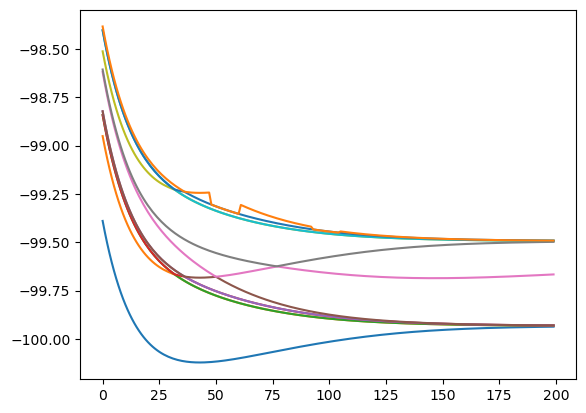

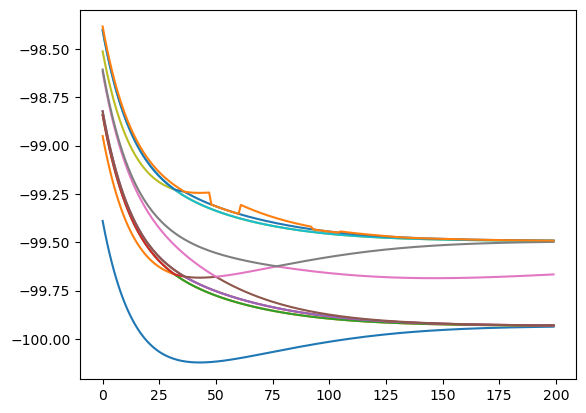

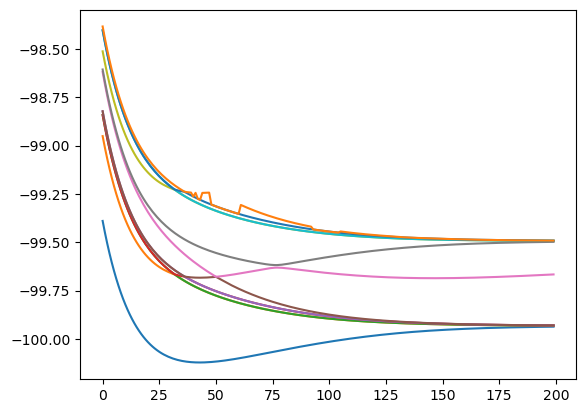

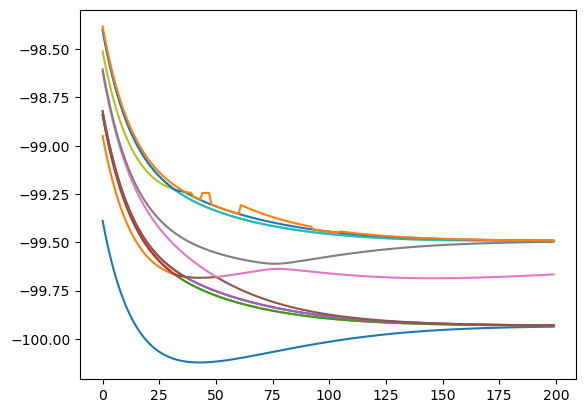

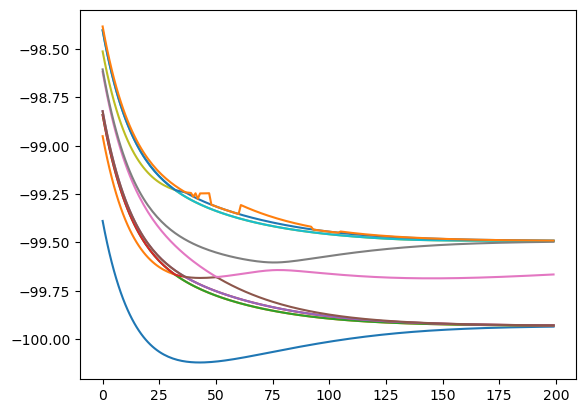

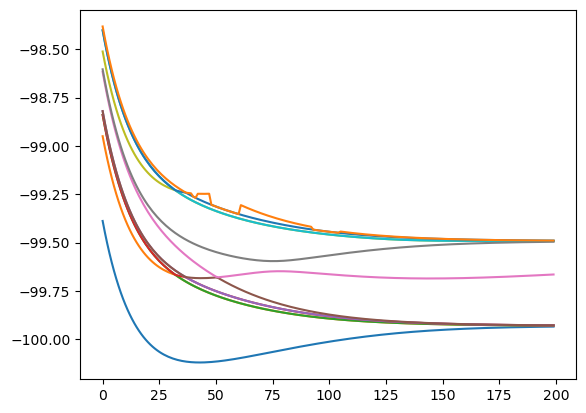

In [630]:
plt.plot(cavity_E_array_0_00_T)
plt.show()
plt.plot(cavity_E_array_0_001_T)
plt.show()
plt.plot(cavity_E_array_0_01_T)
plt.show()
plt.plot(cavity_E_array_0_02_T)
plt.show()
plt.plot(cavity_E_array_0_03_T)
plt.show()
plt.plot(cavity_E_array_0_04_T)
plt.show()

In [631]:
# for i in range(10):
#     cavity_E_array_0_00  = declutter_E_array(cavity_E_array_0_00_T, dipoles_0, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001_T, dipoles_001, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005_T, dipoles_005, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01_T, dipoles_01, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02_T, dipoles_02, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04_T, dipoles_04, r_data, 3, 7,num_to_declutter=12)
#     cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05_T, dipoles_05, r_data, 3, 7,num_to_declutter=12)


cavity_E_array_0_00  = declutter_E_array(cavity_E_array_0_00_T, dipoles_0, r_data, 8, 9,  1,num_to_declutter=12)
cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001_T, dipoles_001, r_data, 8, 9,  1,num_to_declutter=12)
cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005_T, dipoles_005, r_data,6, 6,  1,num_to_declutter=12)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01_T, dipoles_01, r_data, 8, 9,  1,num_to_declutter=12)
cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02_T, dipoles_02, r_data, 8, 3,  1,num_to_declutter=12)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data, 8,3, 1,num_to_declutter=12)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04_T, dipoles_04, r_data,8,3, 1,num_to_declutter=12)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05_T, dipoles_05, r_data, 8,3, 1,num_to_declutter=12)


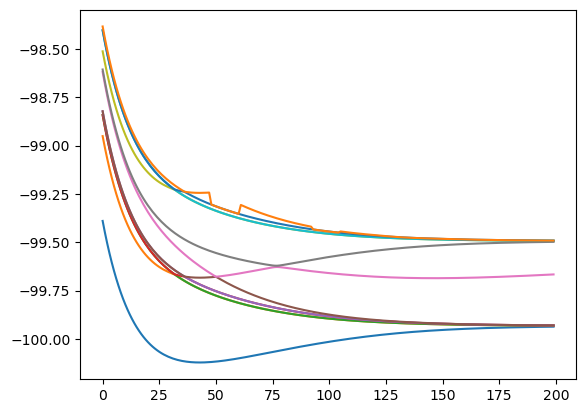

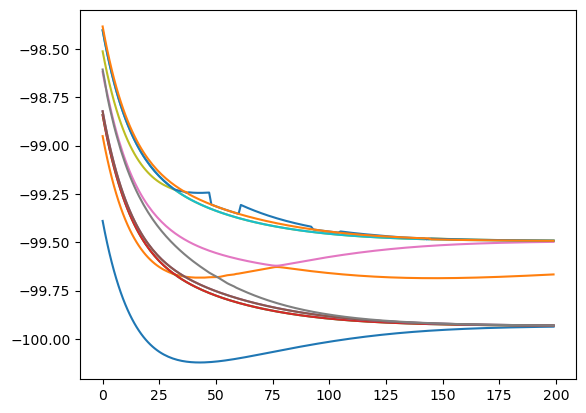

In [632]:
cavity_E_array_0_005_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_005.npy").T

plt.plot(cavity_E_array_0_005_T)
plt.show()

cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005_T, dipoles_005, r_data, 6, 6,  1,num_to_declutter=12)

plt.plot(cavity_E_array_0_005)
plt.show()

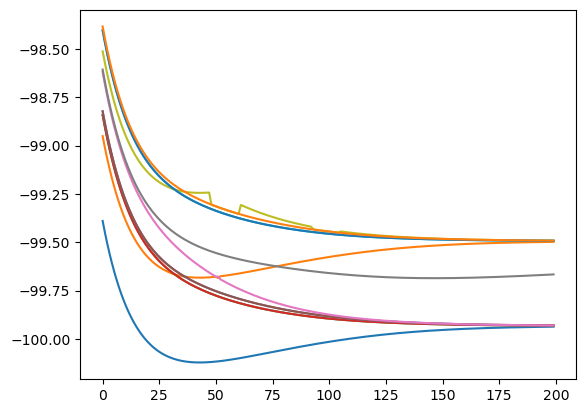

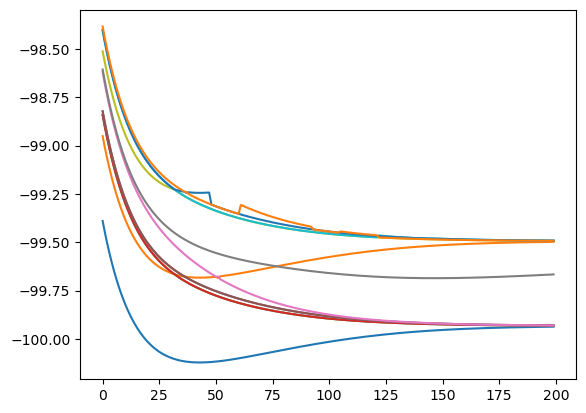

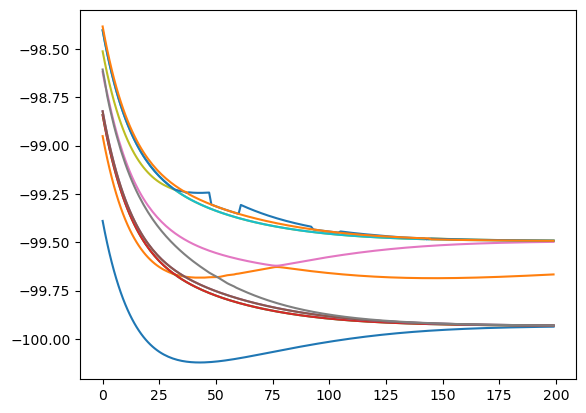

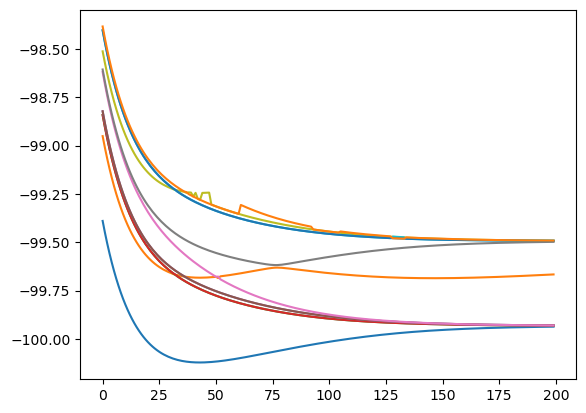

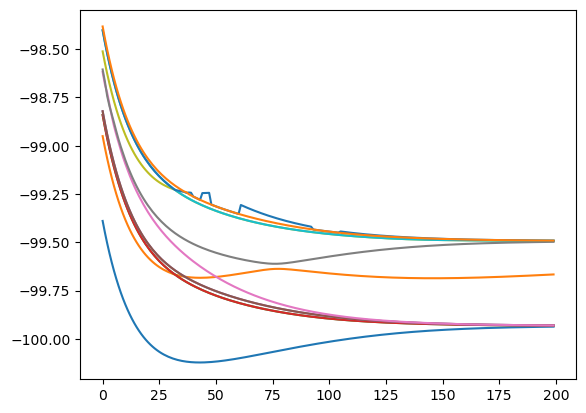

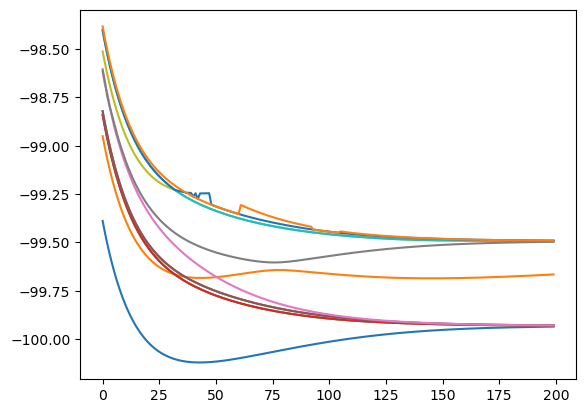

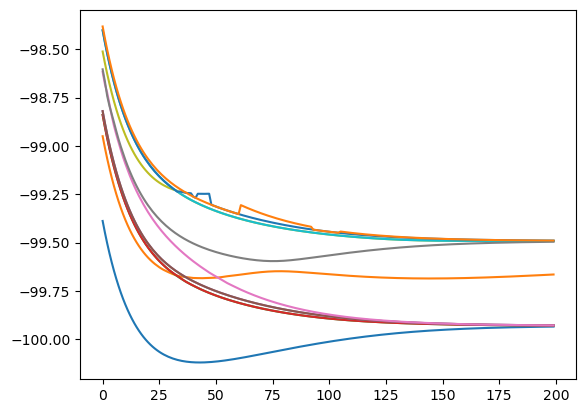

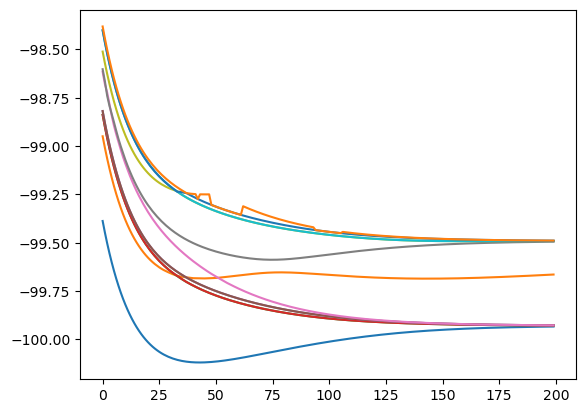

In [633]:
plt.plot(cavity_E_array_0_00)
plt.show()
plt.plot(cavity_E_array_0_001)
plt.show()
plt.plot(cavity_E_array_0_005)
plt.show()
plt.plot(cavity_E_array_0_01)
plt.show()
plt.plot(cavity_E_array_0_02)
plt.show()
plt.plot(cavity_E_array_0_03)
plt.show()
plt.plot(cavity_E_array_0_04)
plt.show()
plt.plot(cavity_E_array_0_05)
plt.show()

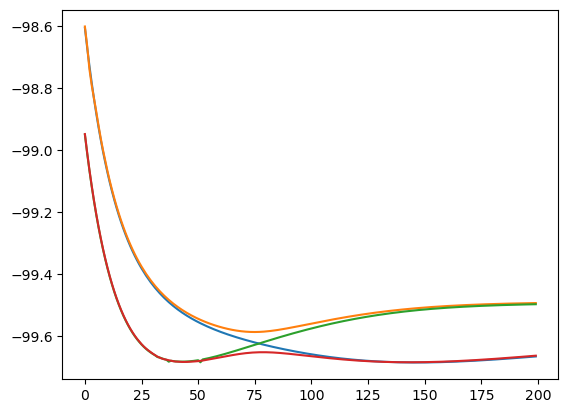

In [634]:
plt.plot(cavity_E_array_0_00[:,7])
plt.plot(cavity_E_array_0_05[:,7])
plt.plot(cavity_E_array_0_00[:,1])
plt.plot(cavity_E_array_0_05[:,1])


In [635]:
S0_array = cavity_E_array_0_00[:,0]
S1_array = cavity_E_array_0_00[:,7]


LP_arrays = np.array([cavity_E_array_0_00[:,1],
            cavity_E_array_0_001[:,1],
            cavity_E_array_0_005[:,1],
            cavity_E_array_0_01[:,1],
            cavity_E_array_0_02[:,1],
            cavity_E_array_0_03[:,1],
            cavity_E_array_0_04[:,1],
            cavity_E_array_0_05[:,1]
                      ]
              )

UP_arrays = np.array([cavity_E_array_0_00[:,7],
            cavity_E_array_0_001[:,7],
            cavity_E_array_0_005[:,6],
            cavity_E_array_0_01[:,7],
            cavity_E_array_0_02[:,7],
            cavity_E_array_0_03[:,7],
            cavity_E_array_0_04[:,7],
            cavity_E_array_0_05[:,7]
                      ]
              )

1.605527638190955
2.5
-0.5463489841038864


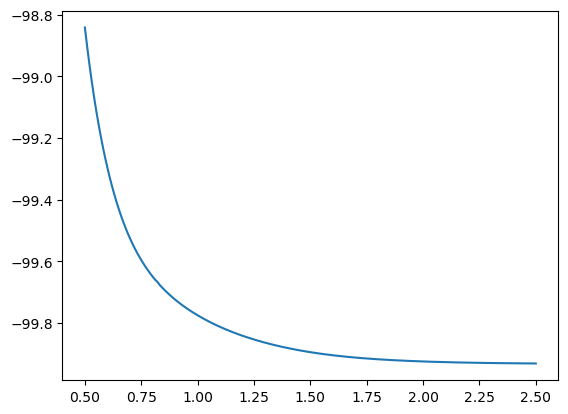

In [636]:
plt.plot(r_data, cavity_E_array_0_001[:,3])

print(r_data[110])
min_loc = np.argmin(cavity_E_array_0_00[:,5])
print(r_data[min_loc])
print(cavity_E_array_0_00[110,0] - cavity_E_array_0_00[110,8])

In [637]:
omega_test = np.abs(cavity_E_array_0_00[74,0] - cavity_E_array_0_00[74, 6])
print(omega_test)
print(r_data[74])

0.2656558756181937
1.2437185929648242


Min on S0 is 0.9321608040201005
Min on S1 is 1.9673366834170853
       14        13         12         11        10        9
0.303 x  - 6.58 x  + 65.41 x  - 394.3 x  + 1610 x  - 4710 x
              8             7             6             5             4
 + 1.018e+04 x - 1.653e+04 x + 2.028e+04 x - 1.877e+04 x + 1.296e+04 x
         3        2
 - 6519 x + 2289 x - 511.8 x - 43.77
914.266490505801


<function matplotlib.pyplot.show(close=None, block=None)>

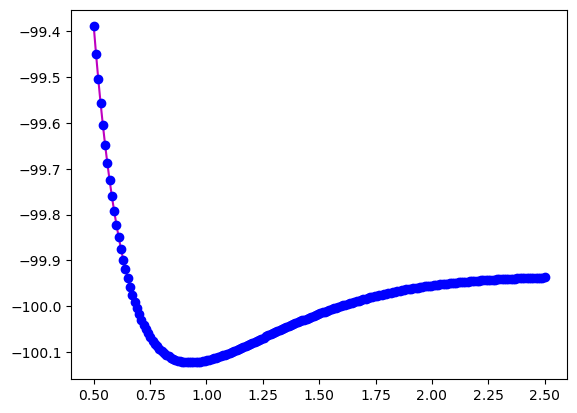

In [638]:

min_S0_loc = np.argmin(S0_array[:])
min_S1_loc = np.argmin(S1_array[:])

min_LP_array = np.zeros((1,8))
min_UP_array = np.zeros((1,8))

for i in range(8):
    min_LP_array[0,i] = np.argmin(LP_arrays[i])
    min_UP_array[0,i] = np.argmin(UP_arrays[i])



r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S1 is {r_data[min_S1_loc]}')
#print(f'Min on LP is {r_data[min_LP_loc]}')
#print(f'Min on UP is {r_data[min_UP_loc]}')

# Fitting S0 PES to a quintic polynomial
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
poly = np.poly1d(np.polyfit(r_data, S0_array, 14))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, S0_array[:], 'bo', label='cavity free |g>')
plt.show

## Calculation of $ \text{x}_0 $

$$ \frac{\hbar}{2}\sqrt{\frac{k}{\mu}} = \frac{k}{2}(x_0 - x_{eq})^2 + V_0 $$

Expanded, solved for $ x_o $, and found zeros using quadratic formula

In [639]:
mu_amu = 1.00784 * 1.00784 / (1.00784 + 1.00784)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
h_bar = constants.hbar
V_0_loc = np.argmin(S0_array)
V_0 = S0_array[V_0_loc] * 4.35974 * 10 ** (-18)
left = (h_bar / 2) * np.sqrt(k_test_SI / mu_kg)
a = 0.5 * k_test_SI 
b = -k_test_SI * r_eq_SI
c = 0.5 * k_test_SI * (r_eq_SI ** 2) - left
zeros_n = (-b - np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
zeros_p = (-b + np.sqrt((b ** 2) - 4 * a * c)) / (2 * a)
x0_angstrom = zeros_n * 10 ** 10
x0_au = x0_angstrom / psi4.constants.bohr2angstroms
print(x0_angstrom)
for i in range(8):
    print(r_data[[int(min_UP_array[0,i])]])

0.822357686965451
[1.96733668]
[1.96733668]
[1.27386935]
[1.2638191]
[1.2638191]
[1.2638191]
[1.25376884]
[1.25376884]


## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [640]:
# Constants and Variables
delta_au = (r_data[min_S1_loc] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms

delta_LP_au = np.zeros((1,8))
delta_UP_au = np.zeros((1,8))

for i in range(8):
    delta_LP_au[0,i] = (r_data[int(min_LP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms
    delta_UP_au[0,i] = (r_data[int(min_UP_array[0,i])] - r_data[min_S0_loc]) / psi4.constants.bohr2angstroms


delta_m = (r_data[min_S1_loc] - r_data[min_S0_loc]) * 10 ** (-10)
delta_angstrom = (r_data[min_S1_loc] - r_data[min_S0_loc])
omega_vib = np.sqrt(k_test_SI / mu_kg)
h_bar = constants.hbar
x0_test = np.sqrt(h_bar * omega_vib / k_test_SI)
x0_test_au = (x0_test * 10 ** (10))  / psi4.constants.bohr2angstroms

# Turner
S_Turner = 0.5 * (delta_au / x0_test_au) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

#g and LP 

HR_LP_array = np.zeros((1,8))
HR_UP_array = np.zeros((1,8))

for i in range(8):
    HR_LP_array[0,i] = 0.5 * (delta_LP_au[0,i] / x0_test_au) ** 2
    HR_UP_array[0,i] = 0.5 * (delta_UP_au[0,i] / x0_test_au) ** 2

print('|g> and |e> HR Factor')
print(S_Turner)
print(S_Hsu)

print('LP and UP HR Factor')
print(HR_LP_array)
print(HR_UP_array)


df = pd.DataFrame(HR_LP_array.reshape(-1,1))
df.to_clipboard()

|g> and |e> HR Factor
44.43947856482571
44.439478564825706
LP and UP HR Factor
[[ 0.26808621  0.26808621 44.43947856 44.43947856 44.43947856 43.58076492
  42.73042896 41.8884707 ]]
[[44.43947856 44.43947856  4.84230721  4.56165446  4.56165446  4.56165446
   4.2893794   4.2893794 ]]


First plot the ground-state potential energy surfaces for $ \text{H2} $ inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

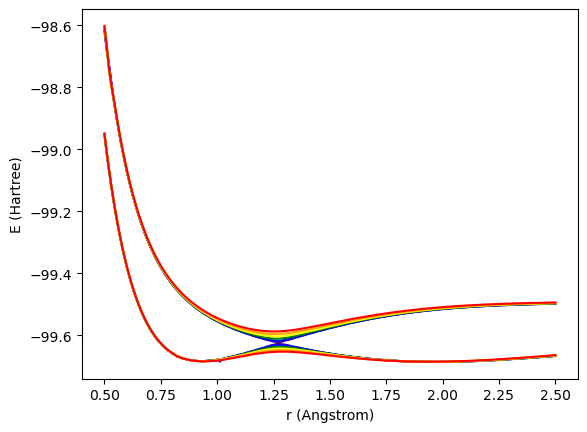

In [641]:
lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
fci_S0_omega = np.zeros((1, N_R))
for i in range(N_R):
    fci_S0_omega[0,i] = S0_array[i] + 0.4388785987545134
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)

color_list_1 = ['grey','violet','indigo','blue','green','yellow','orange','red']

plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')

for i in range(2,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(2,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)

plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
#plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.savefig('polariton_surfaces_HF.png',dpi=500)
#plt.show()

In [642]:
print(cavity_E_array_0_005.shape)

(200, 12)


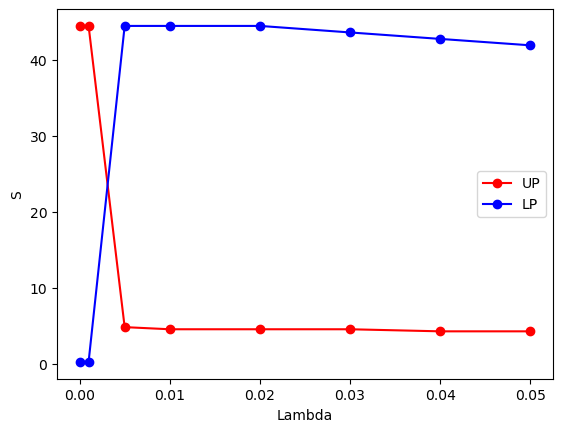

In [643]:
plt.plot(lambda_list, HR_UP_array[0,:], 'ro-', label='UP')
plt.plot(lambda_list, HR_LP_array[0,:], 'bo-', label='LP')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('S')
plt.savefig('H2_trends.png', dpi=1000)

In [644]:
#pd.DataFrame(matrix).to_clipboard()

omega_test = np.abs(fci_S0[100] - fci_S1[100])
print(omega_test)
print(r_data[100])


NameError: name 'fci_S0' is not defined

In [ ]:
lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
fci_S0_omega = np.zeros((1, N_R))
for i in range(N_R):
    fci_S0_omega[0,i] = S0_array[i] + 0.12086
fci_S0_plusw = np.ndarray.flatten(fci_S0_omega)

color_list_1 = ['grey','violet','indigo','blue','green','yellow','orange','red']

plt.plot(r_data, fci_S0_plusw, linestyle='dashed', color='gray', label=f'$\lambda$ = 0')
plt.plot(r_data, S1_array, linestyle='--', color='gray')

for i in range(2,8):
    plt.plot(r_data, LP_arrays[i,:], f'{color_list_1[i]}', label=f'$\lambda$ = {lambda_list[i]}')
for k in range(2,8):
        plt.plot(r_data, UP_arrays[k,:], f'{color_list_1[k]}',)

plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')


#plt.xlim(1.5, 2)
#plt.ylim(-7.76, -7.72)
#plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.axis('off')
plt.savefig('polariton_surfaces_LiH_No_Background.png', transparent=True, dpi=500)
#plt.show()